In [1]:
include("../LiPoSID.jl")

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

using Dates

using HDF5

data_dir = "../DATA/"

γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γ_list_disp = [ "0.0795",  "0.2513", "0.7947", "2.5133", "7.9477", "25.133",  "79.477", "251.33"];

b⁰ = [0, 0, 1, 1]
b¹ = [0, 0, -1, 1]
bˣ = [1, 0, 0, 1]
bʸ = [1, 1, 0, 1]


function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

function SumCoeffs2(poly, s)
    p = SymPy.expand(poly)
    rest_poly = SymPy.subs(p, s => 0)
    degrees = range(1,convert(Int32,SymPy.degree(p, s)))
    
    obj = sum(p.coeff(s^i)^2 for i in degrees) #+ rest_poly^2  
    
    return obj
end 

function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end


function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    #ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])
    ΔG = SymPy.together.(Gˢʸᵐᵇ - Gˢⁱᵈ)

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys.^2, s))

    #objective = sympy_to_dynamicpoly(obj)

    return obj

end

function read_Ac(models_file_name, γ)
    h5open(models_file_name, "r") do file
        Ac = read(file["gamma_"*string(γ)]["Ac"])
        return Ac
    end
end

function dmd_Ac(γ)

    data_dir = "../DATA/"
    
    ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γ)
    ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γ)
    ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γ)
    ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γ)

    Δt = tᵉ[2]-tᵉ[1]

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    Aᴰᴹᴰ⁻ˢᴮ = LiPoSID.direct_DMD_01XY_b4_A([ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]])
    Acᴰᴹᴰ⁻ˢᴮ = log(Aᴰᴹᴰ⁻ˢᴮ)/Δt

    return Acᴰᴹᴰ⁻ˢᴮ

end

function sb_TF_objective(γ, Acˢʸᵐᵇ)
    models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
    Acᴰᴹᴰ = read_Ac(models_file_name, γ)
    obj =  TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bˣ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bʸ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b¹) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b⁰)
    objective = sympy_to_dynamicpoly(obj)
    return objective
end

#Functions for plotting heatmaps

function plot_TF_objective(γ, Aᴸᴹᴱ)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 30, length=1000)
    g = range(-30*γᶠ, 30*γᶠ, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    heatmap(g, w, log.(z))
    contour!(g, w, log.(z))
    title!("γ = "*string(γ))

end


function plot_TF_objective(γ, Aᴸᴹᴱ, γ_lim)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 10, length=1000)
    g = range(-γ_lim, γ_lim, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    #heatmap(g, w, log.(z))
    contour(g, w, log.(z))
    #title!("γ = "*string(γ))
    xlabel!("γ")
    ylabel!("ω")

end

plot_TF_objective (generic function with 2 methods)

In [2]:
ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aˢ = [ -γ/2  ω      0      0  
       -ω   -γ/2    0      0
        0    0     -γ      γ
        0    0      0      0    ] #==#

Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)

4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

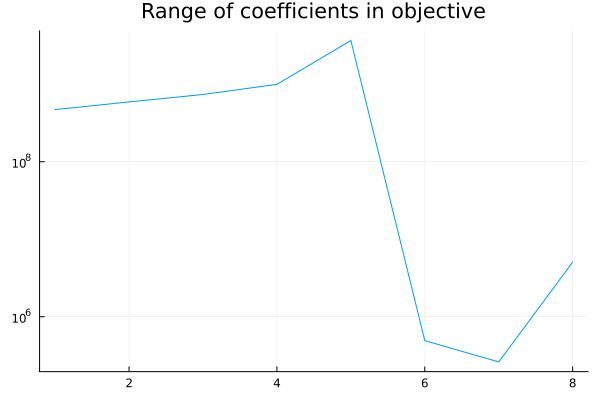

In [3]:
function coef_range(obj)
    maximum(abs.(coefficients(obj)))/minimum(abs.(coefficients(obj)))
end

coef_ranges = []

for γᵢ in  γ_list
    objective = sb_TF_objective(γᵢ, Aᴸᴹᴱ)
    push!(coef_ranges, coef_range(objective))
end
#pyplot()
plot(coef_ranges, yscale=:log10, legend=false)
title!("Range of coefficients in objective")

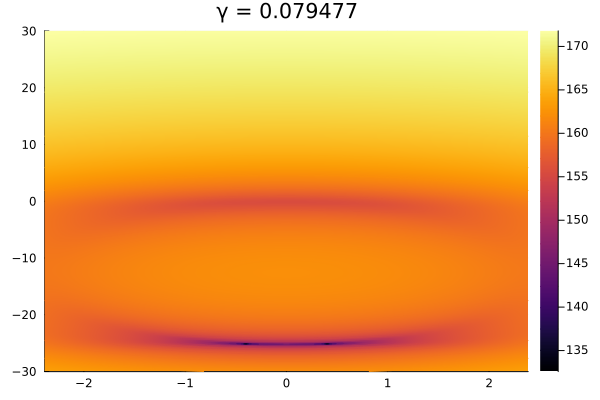

In [4]:
plot_TF_objective(γ_list[1] , Aᴸᴹᴱ) #Aᴸᴹᴱ Aˢ

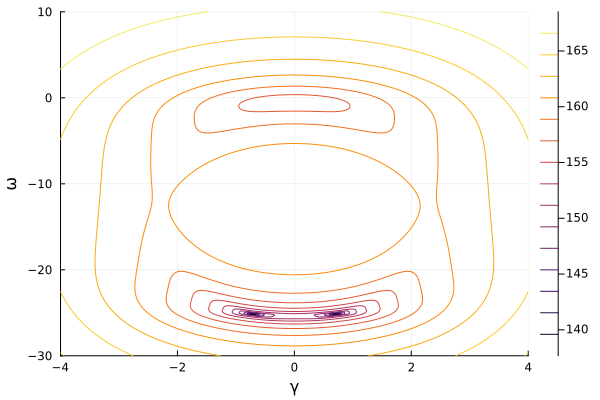

In [5]:
plot_TF_objective(γ_list[2], Aᴸᴹᴱ, 4)

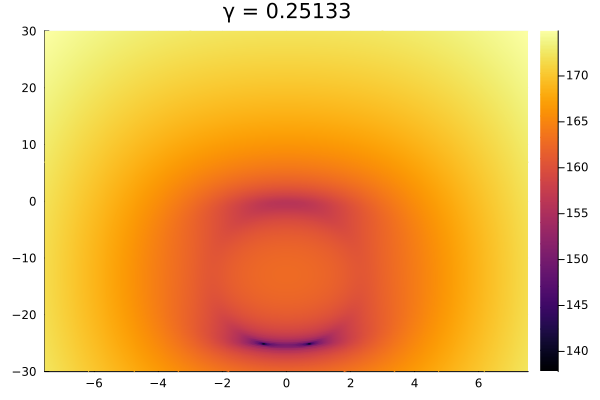

In [6]:
plot_TF_objective(γ_list[2] , Aᴸᴹᴱ ) #Aᴸᴹᴱ Aˢ

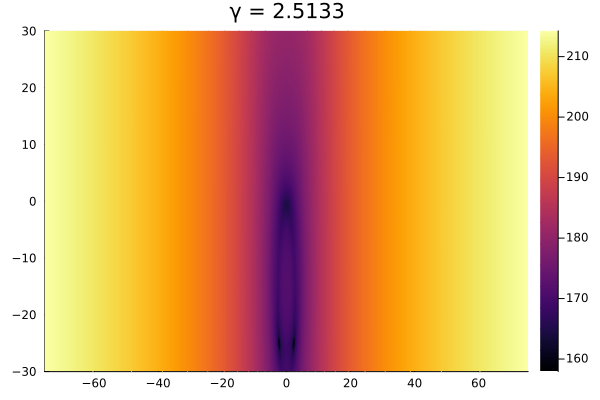

In [7]:
plot_TF_objective(γ_list[4] , Aᴸᴹᴱ) #Aᴸᴹᴱ  Aˢ

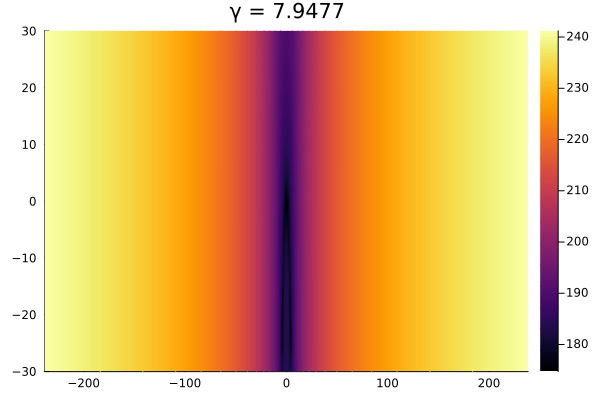

In [8]:
plot_TF_objective(γ_list[5] , Aᴸᴹᴱ) #Aᴸᴹᴱ  Aˢ

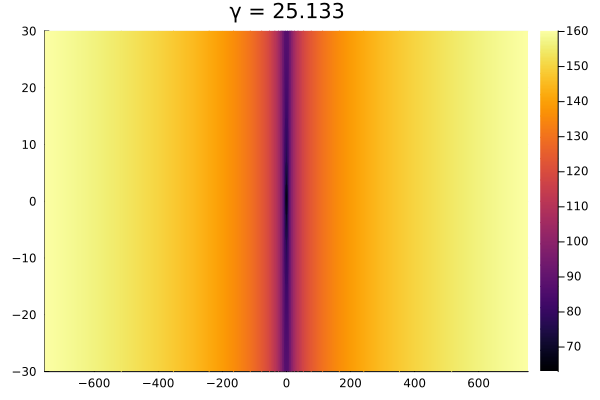

In [9]:
plot_TF_objective(γ_list[6] , Aᴸᴹᴱ)  #Aᴸᴹᴱ  Aˢ

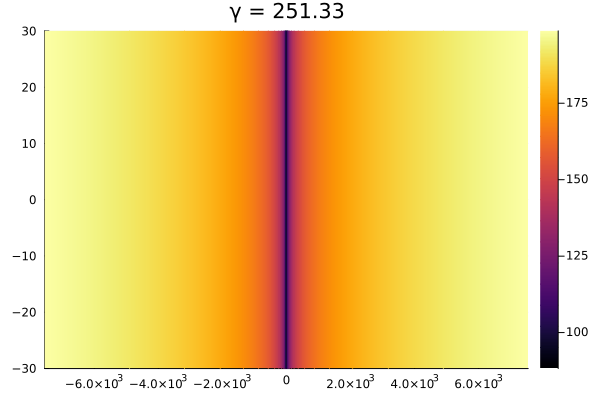

In [10]:
plot_TF_objective(γ_list[8] , Aᴸᴹᴱ)

In [11]:
date_and_time_string =  string(Dates.format(now(), "yyyy-u-dd_at_HH-MM"))
models_file = "DMD_TS_POP_w&g_bx_"*date_and_time_string * ".h5"

models_dir = "../MODELS/"

for γᵢ in  γ_list
    objective = sb_TF_objective(γᵢ, Aᴸᴹᴱ) #Aˢ

    best_solution, best_method = LiPoSID.poly_min(objective) 
    w = DynamicPolynomials.subs(ω, best_solution)
    g = DynamicPolynomials.subs(γ, best_solution)

    h5open(models_dir*models_file,"cw") do fid  # read-write, create file if not existing, preserve existing contents

        γ_group = create_group(fid, "gamma_"*γᵢ)
            
        γ_group["w"] = convert(Float64, w)
        γ_group["g"] = convert(Float64, g)
        γ_group["best_method"] = best_method
        γ_group["coef_range"] = coef_range(objective)
                        
    end
   

end

println(date_and_time_string)

Tracking 105 paths...   2%|▌                            |  ETA: 0:04:49
  # paths tracked:                  2
  # non-singular solutions (real):  0 (0)
  # singular endpoints (real):      0 (0)






Tracking 105 paths... 100%|█████████████████████████████| Time: 0:00:06
  # paths tracked:                  105
  # non-singular solutions (real):  57 (7)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         57 (7)


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...


termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0


The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0


The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0


The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0


The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
The local solver failed refining the solution!
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
Found a locally optimal solution by Ipopt, giving an upper bound: 1146630871424479575951802368.00000000.
The relative optimality gap is: 100.000000%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE


solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
Found a locally optimal solution by Ipopt, giving an upper bound: 1146630871424480812902383616.00000000.
The relative optimality gap is: 100.000000%.
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
Found a locally optimal solution by Ipopt, giving an upper bound: 31610997271671470222309588992.00000000.
The relative optimality gap is: 100.000000%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
Found a locally optimal solution by Ipopt, giving an upper bound: 31610997271671443834030522368.00000000.
The relative optimality gap is: 100.000000%.
No higher TS step of the TSSOS hierarchy!


*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
Found a locally optimal solution by Ipopt, giving an upper bound: 743166770233384484344015355904.00000000.
The relative optimality gap is: 100.000000%.
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: DUAL_INFEASIBLE
solution status: INFEASIBILITY_CERTIFICATE
optimum = 1.0
Found a locally optimal solution by Ipopt, giving an upper bound: 743166770233383921394061934592.00000000.
The relative optimality gap is: 100.000000%.
No higher TS step of the TSSOS hierarchy!
2024-Jan-05_at_13-18
